In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0'
# !git clone https://github.com/bytedance/VideoWorld.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install rotary-embedding-torch
!pip install kornia
!pip install gateloop_transformer
!pip install webdataset

In [3]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

In [4]:
#@title utilities
import torch

def tensor_allclose(a, b, atol=1e-8, rtol=1e-5):
    """
    比较两个张量是否满足：
    |a - b| ≤ atol + rtol * |b|

    参数：
    a, b: 要比较的PyTorch张量
    atol: 绝对容差（默认1e-8）
    rtol: 相对容差（默认1e-5）

    返回：
    bool: 是否所有元素都满足容差要求
    """
    if a.shape != b.shape:
        raise ValueError("张量形状不匹配")

    return torch.allclose(a, b, atol=atol, rtol=rtol)

import torch
import matplotlib.pyplot as plt

def compare_4d_slices(tensor1, tensor2,
                     dim=1,  # 切片维度：1(x),2(y),3(z)
                     index=0,  # 切片索引
                     atol=1e-5,
                     rtol=1e-3):
    """
    四维张量切片对比工具
    返回：
    - 差异统计指标
    - 可视化对比图
    用例：
    # 比较通道维度第50层的切片
    stats, fig = compare_4d_slices(tensor1, tensor2, dim=1, index=50)
    plt.show()
    print(stats)
    """

    # 维度验证
    assert tensor1.shape == tensor2.shape, "张量形状必须相同"
    assert tensor1.dim() == 4, "输入必须是四维张量"
    assert 1 <= dim <= 3, "切片维度需在[1,3]范围内"

    # 切片提取（保持四维结构）
    if dim == 1:
      slice1 = tensor1[0,index,...]
      slice2 = tensor2[0,index,...]
    elif dim == 2:
      slice1 = tensor1[0,:,index,...]
      slice2 = tensor2[0,:,index,...]
    elif dim == 3 or dim == -1:
      slice1 = tensor1[0,...,index]
      slice2 = tensor2[0,...,index]
    # 差异计算
    abs_diff = torch.abs(slice1 - slice2)
    rel_diff = abs_diff / (torch.abs(slice2) + atol)  # 避免除零

    # 统计指标
    stats = {
        'max_abs': abs_diff.max().item(),
        'mean_abs': abs_diff.mean().item(),
        'rel_over_threshold': (rel_diff > rtol).sum().item() / slice1.numel()
    }

    # 可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 原始数据可视化（取三维切片中间层）
    axes[0,0].imshow(slice1.cpu().numpy(), cmap='gray')
    axes[0,0].set_title(f'Tensor1 Slice {dim}-{index}')

    axes[0,1].imshow(slice2.cpu().numpy(), cmap='gray')
    axes[0,1].set_title(f'Tensor2 Slice {dim}-{index}')

    # 差异热图
    diff_map = axes[0,2].imshow(abs_diff.cpu(), cmap='hot')
    plt.colorbar(diff_map, ax=axes[0,2])
    axes[0,2].set_title('Absolute Difference')

    # 差异分布直方图
    axes[1,0].hist(abs_diff.flatten().cpu().numpy(), bins=50)
    axes[1,0].set_xlabel('Absolute Difference')
    axes[1,0].set_ylabel('Frequency')

    # 相对差异分布
    axes[1,1].hist(rel_diff.flatten().cpu().numpy(), bins=50)
    axes[1,1].set_xlabel('Relative Difference')

    plt.tight_layout()

    return stats, fig

import matplotlib.pyplot as plt
import numpy as np

def plot(tensor):
    """
    绘制一个 2D 张量

    参数:
    tensor: PyTorch 张量，形状为 [H, W]
    """
    # 将张量转换为 NumPy 数组
    if tensor.is_cuda:
        tensor = tensor.detach().cpu()

    img = tensor.numpy()

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制热图
    im = plt.imshow(img, cmap='viridis')

    # 添加颜色条
    plt.colorbar(im, label='值')

    # 添加标题和轴标签
    plt.title('地震数据切片可视化')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 显示图形
    plt.tight_layout()
    plt.show()

def downsample_3d_time_aware(x, target_size=(128, 128)):
    B, C, T, H, W = x.shape
    results = []

    # 逐时间步处理
    for t in range(T):
        time_slice = x[:, :, t, :, :]  # [B, C, H, W]
        down_slice = F.interpolate(
            time_slice,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        results.append(down_slice)

    return torch.stack(results, dim=2)  # 重组时间维度

In [5]:
#@title 读取一组时移（地震-河道标签）数据


# Number of time steps
nt = 10  # Adjust based on your actual data

# Initialize empty lists to collect data
all_seismic_data = []
all_channel_data = []

# Base path for your data
base_path = "/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64/"
size = 64
# Loop through all indices
for selected_idx in range(10):  # 0 to 19
    # Load seismic data for current index
    seismic_file = f"{base_path}64_tld_seis_meandering_{selected_idx}.bin"

    # Check if file exists before loading
    if os.path.exists(seismic_file):
        seismic = np.fromfile(seismic_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_seismic_data.append(seismic)

        # Load corresponding channel data
        channel_file = f"{base_path}64_tld_channel_meandering_{selected_idx}.bin"
        channel = np.fromfile(channel_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_channel_data.append(channel)

        print(f"Loaded data for index {selected_idx}")
    else:
        print(f"Warning: File not found for index {selected_idx}")

# Concatenate all loaded data along the first dimension
if all_seismic_data:
    seismic_data_total = np.concatenate(all_seismic_data, axis=0)
    channel_data = np.concatenate(all_channel_data, axis=0)

    print(f"Combined seismic data shape: {seismic_data_total.shape}")  # Should be (20, nt+1, 256, 256, 256)
    print(f"Combined channel data shape: {channel_data.shape}")  # Should be (20, nt+1, 256, 256, 256)
else:
    print("No data was loaded. Check file paths.")




Loaded data for index 0
Loaded data for index 1
Loaded data for index 2
Loaded data for index 3
Loaded data for index 4
Loaded data for index 5
Loaded data for index 6
Loaded data for index 7
Loaded data for index 8
Loaded data for index 9
Combined seismic data shape: (10, 11, 64, 64, 64)
Combined channel data shape: (10, 11, 64, 64, 64)


In [24]:
#@title pre_ae
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Tuple, Union, Optional, List, Literal
from collections import namedtuple
from einops import rearrange, repeat, pack, unpack
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Union, Literal, List

def cast_tuple(t, length=1):
    return t if isinstance(t, tuple) else ((t,) * length)

def divisible_by(num, den):
    return (num % den) == 0

def pad_at_dim(t, pad, dim = -1, value = 0.):
    dims = t.ndim
    if dim < 0:
        dim = dims + dim

    pad_left = pad[0]
    pad_right = pad[1]

    if pad_left == 0 and pad_right == 0:
        return t

    pad_dims = [(0, 0)] * dims
    pad_dims[dim] = (pad_left, pad_right)
    pad_dims = tuple(pad_dims[::-1]) # torch pad requires reversed dims

    return F.pad(t, pad_dims, value = value)


# --- Helper Modules (Adapted for 3D Seismic Data) ---
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_norm=True):
        super().__init__()
        self.use_norm = use_norm
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=not use_norm)
        self.norm1 = nn.GroupNorm(min(32, out_channels) if out_channels >= 1 else 1, out_channels) if use_norm else nn.Identity() # Handle GroupNorm edge case
        self.activation1 = nn.SiLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=not use_norm)
        self.norm2 = nn.GroupNorm(min(32, out_channels) if out_channels >= 1 else 1, out_channels) if use_norm else nn.Identity() # Handle GroupNorm edge case
        self.activation2 = nn.SiLU()

        # Shortcut connection if channels change
        self.shortcut = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.activation1(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        out += residual
        return self.activation2(out)

class Downsample(nn.Module):
    """Downsamples Z, H, W or just H, W"""
    def __init__(self, dim_in, dim_out, with_z=True):
        super().__init__()
        stride = (2, 2, 2) if with_z else (1, 2, 2)
        self.conv = nn.Conv3d(dim_in, dim_out, kernel_size=3, stride=stride, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    """Upsamples Z, H, W or just H, W using trilinear interpolation + Conv"""
    def __init__(self, dim_in, dim_out, with_z=True):
        super().__init__()
        self.with_z = with_z
        scale_factor = (2, 2, 2) if with_z else (1, 2, 2)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='trilinear', align_corners=False)
        self.conv = nn.Conv3d(dim_in, dim_out, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsample(x)
        return self.conv(x)

# --- Seismic Volume Encoder (MODIFIED for 64x64 Latent Output) ---

class SeismicVolumeEncoder(nn.Module):
    def __init__(
        self,
        z_dim=64,
        image_size=64, # H and W dimensions
        input_channels=1,
        latent_dim=256, # Dimension of the output 2D latent space
        init_dim=64,
        # MODIFIED layers: Removed ALL spatial downsampling ('spatial_down', 'z_spatial_down')
        # Channel dimension remains init_dim throughout these layers
        layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
        ),
        input_conv_kernel_size: int = 5,
        z_collapse_kernel_size: int = 3,
        pad_mode: Literal['zeros', 'reflect', 'replicate'] = 'replicate',
    ):
        super().__init__()
        self.input_channels = input_channels
        self.image_size = image_size
        self.z_dim = z_dim
        self.latent_dim = latent_dim # Target latent channel dimension

        self.conv_in = nn.Conv3d(
            input_channels, init_dim, kernel_size=input_conv_kernel_size,
            padding=input_conv_kernel_size // 2, padding_mode=pad_mode
        )

        self.encoder_layers = nn.ModuleList([])
        dim = init_dim
        current_z = z_dim
        current_hw = image_size

        for layer_def in layers:
            layer_type, *layer_params = cast_tuple(layer_def)

            if layer_type == 'consecutive_residual':
                num_consecutive, = layer_params
                # Ensure Residual block uses the current dimension 'dim' (which stays init_dim)
                layer = nn.Sequential(*[Residual(dim, dim) for _ in range(num_consecutive)])
            # Removed 'spatial_down' and 'z_spatial_down' handlers as they are no longer in layers
            # elif layer_type == 'spatial_down': ...
            # elif layer_type == 'z_spatial_down': ...
            else:
                raise ValueError(f'unknown layer type {layer_type}')

            self.encoder_layers.append(layer)

        # Dimensions after the main layers (no downsampling occurred)
        self.final_z_dim = current_z # Should still be z_dim (64)
        self.final_hw_dim = current_hw # Should still be image_size (64)
        self.final_channel_dim = dim # Should still be init_dim (64)

        # Final layer to collapse the Z dimension
        # Input channels: self.final_channel_dim (64)
        # Kernel Z size must match self.final_z_dim (64)
        self.z_collapse_conv = nn.Conv3d(
            self.final_channel_dim, self.final_channel_dim,
            kernel_size=(self.final_z_dim, z_collapse_kernel_size, z_collapse_kernel_size),
            padding=(0, z_collapse_kernel_size // 2, z_collapse_kernel_size // 2)
        )
        self.z_collapse_norm_act = nn.Sequential(
             nn.GroupNorm(min(32, self.final_channel_dim), self.final_channel_dim), # Norm groups for 64 channels
             nn.SiLU()
        )

        # Final projection to latent dimension (2D Conv)
        # Input channels: self.final_channel_dim (64)
        # Output channels: latent_dim (256)
        self.to_latent = nn.Conv2d(self.final_channel_dim, latent_dim, kernel_size=1)

        print(f"Encoder configured:")
        print(f"  Input: ({input_channels}, {z_dim}, {image_size}, {image_size})")
        # Print dimensions *before* Z collapse
        print(f"  After layers (before Z collapse): ({self.final_channel_dim}, {self.final_z_dim}, {self.final_hw_dim}, {self.final_hw_dim})") # Should show (64, 64, 64, 64)
        # Print dimensions *after* Z collapse but *before* final projection
        print(f"  After Z collapse (before to_latent): ({self.final_channel_dim}, 1, {self.final_hw_dim}, {self.final_hw_dim})") # Should show (64, 1, 64, 64)
        print(f"  Latent Output: ({latent_dim}, {self.final_hw_dim}, {self.final_hw_dim})") # Should show (256, 64, 64)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim == 4: # Add channel dim if missing
             x = x.unsqueeze(1)
        # Input assertions
        assert x.shape[1] == self.input_channels, f"Expected {self.input_channels} input channels, got {x.shape[1]}"
        assert x.shape[2] == self.z_dim, f"Expected z_dim={self.z_dim}, got {x.shape[2]}"
        assert x.shape[3] == self.image_size, f"Expected image_size={self.image_size}, got {x.shape[3]}"
        assert x.shape[4] == self.image_size, f"Expected image_size={self.image_size}, got {x.shape[4]}"

        x = self.conv_in(x) # Shape: (B, init_dim, z_dim, image_size, image_size) e.g. (B, 64, 64, 64, 64)

        for layer in self.encoder_layers:
            x = layer(x) # Shape remains (B, 64, 64, 64, 64)

        # Z Collapse
        x = self.z_collapse_conv(x) # Shape: (B, 64, 1, 64, 64)
        x = self.z_collapse_norm_act(x) # Shape: (B, 64, 1, 64, 64)
        x = x.squeeze(2) # Shape: (B, 64, 64, 64)

        # Final projection to latent space
        latent = self.to_latent(x) # Shape: (B, latent_dim, 64, 64) e.g. (B, 256, 64, 64)

        # Output assertions
        assert latent.shape[1] == self.latent_dim
        assert latent.shape[2] == self.final_hw_dim # Should be 64
        assert latent.shape[3] == self.final_hw_dim # Should be 64
        # print(f'Latent output shape:{latent.shape}')
        return latent

# --- Seismic Volume Decoder (MODIFIED for 64x64 Latent Input) ---

class SeismicVolumeDecoder(nn.Module):
    def __init__(
        self,
        z_dim=64,
        image_size=64, # Original H and W dimensions
        output_channels=1,
        latent_dim=256, # Dimension of the input 2D latent space
        init_dim=64,
        # MODIFIED layers: Removed ALL spatial upsampling ('spatial_up', 'z_spatial_up')
        # Channel dimension remains consistent until final conv_out
        layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            # These correspond to the reversed encoder layers
            ('consecutive_residual', 2), # Dim stays same as after z_expand (init_dim = 64)
            ('consecutive_residual', 2), # Dim 64 -> 64
            ('consecutive_residual', 2), # Dim 64 -> 64
            ('consecutive_residual', 2), # Dim 64 -> 64
        ),
        output_conv_kernel_size: int = 5,
        # MODIFIED: Z dim BEFORE encoder collapsed it was the original z_dim (64)
        z_expand_target_dim: int = 64,
        # MODIFIED: Channel dim BEFORE encoder collapsed Z was init_dim (64)
        final_channel_dim_before_collapse: int = 64, # This matches init_dim now
        pad_mode: Literal['zeros', 'reflect', 'replicate'] = 'replicate',
    ):
        super().__init__()
        self.output_channels = output_channels
        self.image_size = image_size # Target output H, W
        self.z_dim = z_dim           # Target output Z
        self.latent_dim = latent_dim # Input latent channel dim
        self.z_expand_target_dim = z_expand_target_dim # Target Z dim after expansion (64)
        self.final_channel_dim_before_collapse = final_channel_dim_before_collapse # Channel dim for z_expand (64)

        # Initial projection from latent space (2D Conv)
        # Input: latent_dim (256)
        # Output: final_channel_dim_before_collapse (64)
        self.from_latent = nn.Conv2d(latent_dim, self.final_channel_dim_before_collapse, kernel_size=1)

        # Layer to expand Z dimension back
        # Input/Output channels: final_channel_dim_before_collapse (64)
        self.z_expand_upsample = nn.Upsample(
            scale_factor=(self.z_expand_target_dim, 1, 1), # Expand Z to 64
            mode='trilinear', align_corners=False
        )
        self.z_expand_conv = nn.Conv3d(
            self.final_channel_dim_before_collapse, self.final_channel_dim_before_collapse,
            kernel_size=3, padding=1
        )
        self.z_expand_norm_act = nn.Sequential(
             nn.GroupNorm(min(32, self.final_channel_dim_before_collapse), self.final_channel_dim_before_collapse), # Norm groups for 64 channels
             nn.SiLU()
        )

        self.decoder_layers = nn.ModuleList([])
        # Start with the channel dimension after Z expand (64)
        dim = self.final_channel_dim_before_collapse

        for layer_def in layers:
            layer_type, *layer_params = cast_tuple(layer_def)

            if layer_type == 'consecutive_residual':
                num_consecutive, = layer_params
                # Ensure Residual block uses the current dimension 'dim' (which stays 64)
                layer = nn.Sequential(*[Residual(dim, dim) for _ in range(num_consecutive)])
            # Removed 'spatial_up' and 'z_spatial_up' handlers
            # elif layer_type == 'spatial_up': ...
            # elif layer_type == 'z_spatial_up': ...
            else:
                raise ValueError(f'unknown layer type {layer_type}')

            self.decoder_layers.append(layer)

        # Final convolution to match output channels
        # Input dim is the dim after the layers (should still be 64)
        self.conv_out = nn.Conv3d(
            dim, output_channels, kernel_size=output_conv_kernel_size,
            padding=output_conv_kernel_size // 2, padding_mode=pad_mode
        )
        self.final_activation = nn.Tanh() # Or Sigmoid, depending on expected output range

        print(f"Decoder configured:")
        print(f"  Latent Input: ({latent_dim}, {image_size}, {image_size})") # Should show (256, 64, 64)
        # Print dimensions *after* Z expansion
        print(f"  After Z expand: ({self.final_channel_dim_before_collapse}, {self.z_expand_target_dim}, {image_size}, {image_size})") # Should show (64, 64, 64, 64)
        print(f"  Final Dim before conv_out: {dim}") # Should be 64
        print(f"  Output: ({output_channels}, {z_dim}, {image_size}, {image_size})") # Should show (1, 64, 64, 64)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input assertions (assuming batch dim is present)
        assert x.ndim == 4, f"Expected 4D latent input (B, C, H, W), got {x.ndim}D"
        assert x.shape[1] == self.latent_dim, f"Expected latent_dim={self.latent_dim}, got {x.shape[1]}"
        assert x.shape[2] == self.image_size, f"Expected latent H={self.image_size}, got {x.shape[2]}"
        assert x.shape[3] == self.image_size, f"Expected latent W={self.image_size}, got {x.shape[3]}"

        # Project latent space
        x = self.from_latent(x) # Shape: (B, 64, 64, 64)

        # Expand Z dimension
        x = x.unsqueeze(2) # Add Z dim: (B, 64, 1, 64, 64)
        x = self.z_expand_upsample(x) # Shape: (B, 64, 64, 64, 64) - Z expanded
        x = self.z_expand_conv(x) # Shape: (B, 64, 64, 64, 64)
        x = self.z_expand_norm_act(x) # Shape: (B, 64, 64, 64, 64)

        # Apply main decoder layers
        for layer in self.decoder_layers:
            x = layer(x) # Shape remains (B, 64, 64, 64, 64)

        # Final output convolution
        x = self.conv_out(x) # Shape: (B, output_channels, 64, 64, 64) e.g. (B, 1, 64, 64, 64)
        x = self.final_activation(x)

        # Output assertions
        assert x.shape[1] == self.output_channels
        assert x.shape[2] == self.z_dim
        assert x.shape[3] == self.image_size
        assert x.shape[4] == self.image_size

        return x

# Make sure the parameters match between encoder and decoder where necessary
# (e.g., latent_dim, init_dim, dimensions corresponding to up/downsampling stages)

class SeismicDimensionAutoencoder(nn.Module):
    """
    Autoencoder using the modified Encoder and Decoder
    for 3D -> 2D latent (64x64 spatial) -> 3D seismic data transformation.
    NO skip connections are used.
    """

    def __init__(
        self,
        z_dim: int = 64,
        image_size: int = 64, # H and W dimensions
        input_channels: int = 1,
        output_channels: int = 1, # Typically same as input for reconstruction
        latent_dim: int = 256,    # Dimension of the 2D latent space
        init_dim: int = 64,       # Initial channel dimension
        # MODIFIED default encoder layers for 64x64 latent HW
        encoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
            ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
        ),
        # MODIFIED default decoder layers to match encoder changes (no spatial upsampling)
        decoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
            # Reverse of modified encoder layers
            ('consecutive_residual', 2),      # Dim 64 (starts after z_expand)
            ('consecutive_residual', 2),      # Dim 64
            ('consecutive_residual', 2),      # Dim 64
            ('consecutive_residual', 2),      # Dim 64
        ),
        input_conv_kernel_size: int = 5,
        output_conv_kernel_size: int = 5,
        z_collapse_kernel_size: int = 3,
        pad_mode: Literal['zeros', 'reflect', 'replicate'] = 'replicate',
    ):
        """
        Initializes the Autoencoder with architecture targeting 64x64 latent space.

        Args:
            z_dim: Depth dimension of the input volume.
            image_size: Height and Width dimensions of the input volume.
            input_channels: Number of channels in the input volume (e.g., 1).
            output_channels: Number of channels in the reconstructed volume.
            latent_dim: Dimension of the intermediate 2D latent space.
            init_dim: Initial number of channels after the first convolution.
            encoder_layers: Tuple defining the encoder architecture. Defaults aim for 64x64 latent.
            decoder_layers: Tuple defining the decoder architecture. Defaults mirror encoder for 64x64 latent.
            input_conv_kernel_size: Kernel size for the encoder's input conv.
            output_conv_kernel_size: Kernel size for the decoder's output conv.
            z_collapse_kernel_size: Kernel size for the Z-dimension collapse conv in encoder.
            pad_mode: Padding mode for convolutions.
        """
        super().__init__()

        print("--- Initializing SeismicDimensionAutoencoder (for 64x64 latent) ---")

        # --- Instantiate Encoder ---
        # Uses the provided or default modified encoder_layers (for 64x64 latent)
        self.encoder = SeismicVolumeEncoder(
            z_dim=z_dim,
            image_size=image_size,
            input_channels=input_channels,
            latent_dim=latent_dim,
            init_dim=init_dim,
            layers=encoder_layers,
            input_conv_kernel_size=input_conv_kernel_size,
            z_collapse_kernel_size=z_collapse_kernel_size,
            pad_mode=pad_mode,
        )

        # --- Determine Decoder Parameters from Encoder ---
        # This automatically gets the correct dimensions from the instantiated MODIFIED encoder.
        # Expected values for 64x64 latent encoder:
        # final_channel_dim_before_collapse = init_dim (e.g., 64)
        # z_expand_target_dim = z_dim (e.g., 64)
        final_channel_dim_before_collapse = self.encoder.final_channel_dim
        z_expand_target_dim = self.encoder.final_z_dim
        print(f"Autoencoder derived from encoder: final_channel_dim={final_channel_dim_before_collapse}, z_expand_target_dim={z_expand_target_dim}")


        # --- Instantiate Decoder ---
        # Uses the provided or default modified decoder_layers and parameters from encoder
        self.decoder = SeismicVolumeDecoder(
            z_dim=z_dim,
            image_size=image_size, # Decoder reconstructs to original image size
            output_channels=output_channels,
            latent_dim=latent_dim,
            init_dim=init_dim, # Decoder aims to return to this dim before final conv
            layers=decoder_layers,
            output_conv_kernel_size=output_conv_kernel_size,
            z_expand_target_dim=z_expand_target_dim, # Should be z_dim (64) from modified encoder
            final_channel_dim_before_collapse=final_channel_dim_before_collapse, # Should be init_dim (64) from modified encoder
            pad_mode=pad_mode,
        )
        print("--- SeismicDimensionAutoencoder Initialization Complete ---")

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the autoencoder.

        Args:
            x: Input seismic volume tensor, shape (B, C, Z, H, W) or (B, Z, H, W).

        Returns:
            A tuple containing:
            - reconstructed (Tensor): The reconstructed seismic volume,
                                     shape (B, C_out, Z, H, W).
            - latent (Tensor): The intermediate 2D latent representation,
                               shape (B, latent_dim, H', W') where H'=W'=64.
        """
        # Store original shape characteristics for potential output adjustment
        original_ndim = x.ndim
        # original_channels = x.shape[1] if original_ndim == 5 else 1 # Not strictly needed unless adjusting output channels based on input

        # 1. Encode the input volume to get the 2D latent representation
        latent = self.encoder(x)
        # Expected latent shape: (B, latent_dim, 64, 64)

        # 2. Decode the latent representation back into a 3D volume
        reconstructed = self.decoder(latent)
        # Reconstructed shape: (B, output_channels, Z, H, W)

        # 3. Adjust output shape if input was (B, Z, H, W) and output is (B, 1, Z, H, W)
        #    This is only relevant if output_channels is fixed to 1 and input might lack channel dim.
        if original_ndim == 4 and reconstructed.shape[1] == 1 and self.decoder.output_channels == 1:
             reconstructed = reconstructed.squeeze(1) # Remove channel dim if input didn't have it

        return reconstructed, latent

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os

class SeismicVolumeDataset(Dataset):
    """
    Dataset for loading individual 3D seismic volumes.
    Assumes input data shape is (N, Z, H, W) or (N, C, Z, H, W).
    """
    def __init__(self, data: np.ndarray, expected_channels: int = 1):
        """
        Args:
            data (np.ndarray): The seismic data array, shape (N, ...)
            expected_channels (int): The number of channels the model expects.
                                     If data shape is (N, Z, H, W) and expected_channels=1,
                                     a channel dimension will be added.
        """
        super().__init__()
        self.data = data.astype(np.float32) # Ensure data is float32 for PyTorch
        self.expected_channels = expected_channels

        if self.data.ndim == 4 and self.expected_channels == 1:
            # Input is (N, Z, H, W), add channel dim -> (N, 1, Z, H, W)
            self.data = np.expand_dims(self.data, axis=1)
            print(f"Dataset: Added channel dimension. New data shape: {self.data.shape}")
        elif self.data.ndim == 5:
            # Input is (N, C, Z, H, W)
            if self.data.shape[1] != self.expected_channels:
                 raise ValueError(f"Data has {self.data.shape[1]} channels, but model expects {self.expected_channels}")
            print(f"Dataset: Using existing {self.data.shape[1]} channels. Data shape: {self.data.shape}")
        elif self.data.ndim != 4 and self.data.ndim != 5: # Check for both 4 and 5 explicitly
             raise ValueError(f"Unsupported data ndim: {self.data.ndim}. Expected 4 or 5.")

        # Store dimensions for model instantiation verification
        self.num_samples = self.data.shape[0]
        self.actual_channels = self.data.shape[1]
        self.z_dim = self.data.shape[2]
        self.image_size_h = self.data.shape[3]
        self.image_size_w = self.data.shape[4]
        if self.image_size_h != self.image_size_w:
            print(f"Warning: Dataset H ({self.image_size_h}) and W ({self.image_size_w}) dimensions differ. Model assumes square H=W.")
        # Add check for square image size if model requires it
        elif 'image_size' in locals() and self.image_size_h != image_size:
             print(f"Warning: Dataset H/W ({self.image_size_h}) differs from model's expected square image_size ({image_size})")


    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        # Get the volume (already has channel dim if needed)
        # Shape: (C, Z, H, W)
        volume = self.data[idx]
        return torch.from_numpy(volume) # .float() is implicitly handled by astype(np.float32)

def train_dimension_autoencoder(
    seismic_data: np.ndarray,
    model_save_path: str,
    # Model parameters (should match data and desired architecture)
    z_dim: int,
    image_size: int, # Assuming H=W for simplicity in model definition
    input_channels: int = 1,
    latent_dim: int = 256,
    init_dim: int = 64,
    # MODIFIED Encoder Layers for 64x64 Latent Output (No spatial downsampling)
    encoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
        ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
        ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
        ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
        ('consecutive_residual', 2),      # Dim 64, Z 64, HW 64
    ),
    # MODIFIED Decoder Layers (No spatial upsampling)
    decoder_layers: Tuple[Union[str, Tuple[str, int]], ...] = (
        # Reverse of modified encoder layers
        ('consecutive_residual', 2),      # Dim 64 (starts after z_expand)
        ('consecutive_residual', 2),      # Dim 64
        ('consecutive_residual', 2),      # Dim 64
        ('consecutive_residual', 2),      # Dim 64
    ),
    # Training parameters
    epochs: int = 50,
    batch_size: int = 4,
    learning_rate: float = 1e-4,
    load_checkpoint: bool = False,
    checkpoint_path: Optional[str] = None # Optional path to load specific checkpoint
) -> nn.Module:
    """
    Trains the SeismicDimensionAutoencoder (configured for 64x64 latent by default).

    Args:
        seismic_data (np.ndarray): Input data array (N, Z, H, W) or (N, C, Z, H, W).
        model_save_path (str): Path to save the final trained model state dict.
                               Directory will be created if it doesn't exist.
        z_dim (int): Depth dimension of the volumes.
        image_size (int): Height/Width dimension of the volumes (assumed square).
        input_channels (int): Number of input channels.
        latent_dim (int): Dimension of the 2D latent space.
        init_dim (int): Initial channel dimension in the model.
        encoder_layers (Tuple): Encoder layer configuration. Defaults target 64x64 latent.
        decoder_layers (Tuple): Decoder layer configuration. Defaults target 64x64 latent.
        epochs (int): Number of training epochs.
        batch_size (int): Training batch size.
        learning_rate (float): Optimizer learning rate.
        load_checkpoint (bool): Whether to load a checkpoint before training.
        checkpoint_path (Optional[str]): Path to the checkpoint file to load.
                                         If None and load_checkpoint is True, uses model_save_path.

    Returns:
        nn.Module: The trained autoencoder model.
    """

    # --- 1. Setup Device ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- 2. Create Dataset and DataLoader ---
    print("Creating Dataset...")
    # Ensure SeismicVolumeDataset is defined or imported
    dataset = SeismicVolumeDataset(seismic_data, expected_channels=input_channels)
    # Consider adjusting num_workers based on your system
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=min(4, os.cpu_count() or 1), pin_memory=True if device.type == 'cuda' else False)

    # Verify dataset dimensions match model parameters
    if dataset.z_dim != z_dim:
        raise ValueError(f"Dataset Z dimension ({dataset.z_dim}) does not match model z_dim ({z_dim})")
    if dataset.image_size_h != image_size or dataset.image_size_w != image_size:
         # Be more specific about the mismatch
         raise ValueError(f"Dataset H/W dimensions ({dataset.image_size_h}/{dataset.image_size_w}) "
                          f"do not match model's expected square image_size ({image_size})")
    if dataset.actual_channels != input_channels:
         raise ValueError(f"Dataset channels ({dataset.actual_channels}) do not match model input_channels ({input_channels})")

    print(f"Dataset created with {len(dataset)} samples.")
    print(f"Sample shape from dataset: {dataset[0].shape}") # Verify shape (C, Z, H, W)

    # --- 3. Create Model ---
    print("Creating Model (targeting 64x64 latent by default)...")
    # Ensure SeismicDimensionAutoencoder is defined or imported
    model = SeismicDimensionAutoencoder(
        z_dim=z_dim,
        image_size=image_size,
        input_channels=input_channels,
        output_channels=input_channels, # Reconstruct same number of channels
        latent_dim=latent_dim,
        init_dim=init_dim,
        encoder_layers=encoder_layers, # Use the (potentially modified) layers
        decoder_layers=decoder_layers  # Use the (potentially modified) layers
        # Add other relevant parameters if needed (kernel sizes, pad_mode)
        # e.g., pad_mode='replicate' if that's consistent
    )
    model = model.to(device)
    print("Model created and moved to device.")
    # print(model) # Optional: Print model structure

    # --- 4. Load Checkpoint (Optional) ---
    load_path = checkpoint_path if checkpoint_path else model_save_path
    start_epoch = 0 # Initialize start epoch
    if load_checkpoint:
        # Check if the target file exists before attempting to load
        if os.path.isfile(load_path):
            try:
                print(f"Loading checkpoint from: {load_path}")
                # Load checkpoint, potentially including optimizer state and epoch
                checkpoint = torch.load(load_path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state too
                # start_epoch = checkpoint['epoch'] # Resume from next epoch
                print("Checkpoint loaded successfully.")
                # print(f"Resuming training from epoch {start_epoch + 1}")
            except KeyError as e:
                 print(f"Warning: Checkpoint missing key {e}. Loading model state dict only.")
                 try: # Attempt to load just the state dict if keys are missing
                     model.load_state_dict(torch.load(load_path, map_location=device))
                     print("Loaded model state dict directly.")
                 except Exception as inner_e:
                     print(f"Warning: Error loading state dict directly: {inner_e}. Training from scratch.")
                     start_epoch = 0 # Reset epoch count
            except Exception as e:
                print(f"Warning: Error loading checkpoint: {e}. Training from scratch.")
                start_epoch = 0 # Reset epoch count
        else:
            print(f"Warning: Checkpoint file not found at {load_path}. Training from scratch.")

    # --- 5. Loss and Optimizer ---
    criterion = nn.MSELoss() # Mean Squared Error is common for reconstruction
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Added weight decay
    # Consider using a learning rate scheduler
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    print("Loss function and optimizer created.")

    # --- 6. Training Loop ---
    print(f"Starting training from epoch {start_epoch + 1}...")
    best_loss = float('inf') # Keep track of best loss for saving best model

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0.0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in progress_bar:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed, latent = model(batch)

            # Ensure shapes match for loss calculation
            if reconstructed.shape != batch.shape:
                 raise RuntimeError(f"Shape mismatch! Reconstructed: {reconstructed.shape}, Input Batch: {batch.shape}")

            loss = criterion(reconstructed, batch)
            loss.backward()
            # Optional: Gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}") # Format loss in progress bar

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_loss:.6f}")

        # Update learning rate scheduler if used
        # scheduler.step(avg_loss)

        # Save checkpoint (potentially including optimizer state and epoch)
        # Save if this epoch is better than the best seen so far
        if avg_loss < best_loss:
             best_loss = avg_loss
             print(f"New best loss: {best_loss:.6f}. Saving model checkpoint...")
             # Ensure directory exists
             save_dir = os.path.dirname(model_save_path)
             if save_dir: # Only create if dirname is not empty (i.e., not saving in current dir)
                 os.makedirs(save_dir, exist_ok=True)

             try:
                 # Save more comprehensive checkpoint
                 torch.save({
                     'epoch': epoch + 1, # Save next epoch number to start from
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'loss': avg_loss,
                 }, model_save_path)
                 print(f"Model checkpoint saved to {model_save_path}")
             except Exception as e:
                 print(f"Error saving model checkpoint: {e}")


    # --- 7. Final Message ---
    print(f"Training finished after {epochs} epochs.")
    print(f"Final model state dict saved at epoch {start_epoch + epochs} with loss {best_loss:.6f} to {model_save_path}") # Reflect last saved epoch

    # Load the best model state before returning (optional, but good practice)
    try:
        best_checkpoint = torch.load(model_save_path, map_location=device)
        model.load_state_dict(best_checkpoint['model_state_dict'])
        print("Loaded best model state dict before returning.")
    except Exception as e:
        print(f"Warning: Could not reload best model state dict after training: {e}")


    return model

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def train():
    print("--- Starting Main Training Script ---")

    # 1. Prepare your data
    print("Preparing data...")
    num_samples = 20
    z_dim_data = 64
    h_dim_data = 64
    w_dim_data = 64
    channels_data = 11 # Original number of channels

    # Creating dummy data for demonstration:
    print(f"Creating dummy data with shape: ({num_samples}, {channels_data}, {z_dim_data}, {h_dim_data}, {w_dim_data})")
    # seismic_data_total already exists.
    print(f"Original data shape (seismic_data_total): {seismic_data_total.shape}")

    # Reshape data for training: Combisne sample and channel dimensions for AE input
    # The model expects (N', C_model, Z, H, W) where C_model is model_input_channels (e.g., 1)
    # New N' will be num_samples * channels_data
    seismic_data_mass = seismic_data_total.reshape(-1, 1, z_dim_data, h_dim_data, w_dim_data)
    print(f"Reshaped data shape for training (seismic_data_mass): {seismic_data_mass.shape}")
    print(f"Total training samples after reshape: {seismic_data_mass.shape[0]}")

    # 2. Define parameters
    print("Defining model and training parameters...")
    # Ensure Google Drive is mounted if using Colab, or adjust path as needed
    save_path = "/content/drive/MyDrive/DiTing2.0/ckp/seismic_autoencoder_epoch_5.pt"
    model_z_dim = z_dim_data          # Should match data Z dimension
    model_image_size = h_dim_data     # Should match data H/W dimensions
    model_input_channels = 1          # Set to 1 because we reshaped the data
    model_latent_dim = 30              # Target latent dimension size
    model_init_dim = 64               # Initial dimension for the model conv layers
    num_epochs = 4                    # Number of training epochs
    batch_size_train = 8              # Batch size for training
    load_prev_checkpoint = False       # Set to True to attempt loading from save_path

    # 3. Train the model
    print("Starting training process...")
    try:
        trained_model = train_dimension_autoencoder(
            seismic_data=seismic_data_mass,
            model_save_path=save_path,
            z_dim=model_z_dim,
            image_size=model_image_size,
            input_channels=model_input_channels,
            latent_dim=model_latent_dim,
            init_dim=model_init_dim, # Pass init_dim
            # Using default encoder/decoder layers for 64x64 latent from the function definition
            epochs=num_epochs,
            batch_size=batch_size_train,
            learning_rate=1e-4, # Keep default or specify if needed
            load_checkpoint=load_prev_checkpoint,
            checkpoint_path=save_path # Explicitly pass path for loading if load_checkpoint is True
        )
        print("\nTraining function execution complete.")
        # print(trained_model)

    except FileNotFoundError as e:
          print(f"\nError: Data file not found. Please check the path. Details: {e}")
    except ValueError as e:
          print(f"\nError: Dimension mismatch or invalid parameter. Details: {e}")
    except NameError as e:
        print(f"\nError: A required class or function is not defined.")
        print("Please ensure SeismicVolumeDataset, SeismicDimensionAutoencoder (64x64 latent version),")
        print("and train_dimension_autoencoder are defined before this script block.")
        print(f"Details: {e}")
    except Exception as e:
          # Catch any other unexpected errors during training
          print(f"\nAn unexpected error occurred during training: {e}")
          import traceback
          traceback.print_exc() # Print detailed traceback for debugging

    print("\n--- Main Training Script Finished ---")

In [25]:
train()

--- Starting Main Training Script ---
Preparing data...
Creating dummy data with shape: (20, 11, 64, 64, 64)
Original data shape (seismic_data_total): (10, 11, 64, 64, 64)
Reshaped data shape for training (seismic_data_mass): (110, 1, 64, 64, 64)
Total training samples after reshape: 110
Defining model and training parameters...
Starting training process...
Using device: cpu
Creating Dataset...
Dataset: Using existing 1 channels. Data shape: (110, 1, 64, 64, 64)
Dataset created with 110 samples.
Sample shape from dataset: torch.Size([1, 64, 64, 64])
Creating Model (targeting 64x64 latent by default)...
--- Initializing SeismicDimensionAutoencoder (for 64x64 latent) ---
Encoder configured:
  Input: (1, 64, 64, 64)
  After layers (before Z collapse): (64, 64, 64, 64)
  After Z collapse (before to_latent): (64, 1, 64, 64)
  Latent Output: (30, 64, 64)
Autoencoder derived from encoder: final_channel_dim=64, z_expand_target_dim=64
Decoder configured:
  Latent Input: (30, 64, 64)
  After Z e

Epoch 1/4 completed. Average Loss: 0.069697
New best loss: 0.069697. Saving model checkpoint...
Model checkpoint saved to /content/drive/MyDrive/DiTing2.0/ckp/seismic_autoencoder_epoch_5.pt


Epoch 2/4 completed. Average Loss: 0.019705
New best loss: 0.019705. Saving model checkpoint...
Model checkpoint saved to /content/drive/MyDrive/DiTing2.0/ckp/seismic_autoencoder_epoch_5.pt


Epoch 3/4 completed. Average Loss: 0.014002
New best loss: 0.014002. Saving model checkpoint...
Model checkpoint saved to /content/drive/MyDrive/DiTing2.0/ckp/seismic_autoencoder_epoch_5.pt


KeyboardInterrupt: 

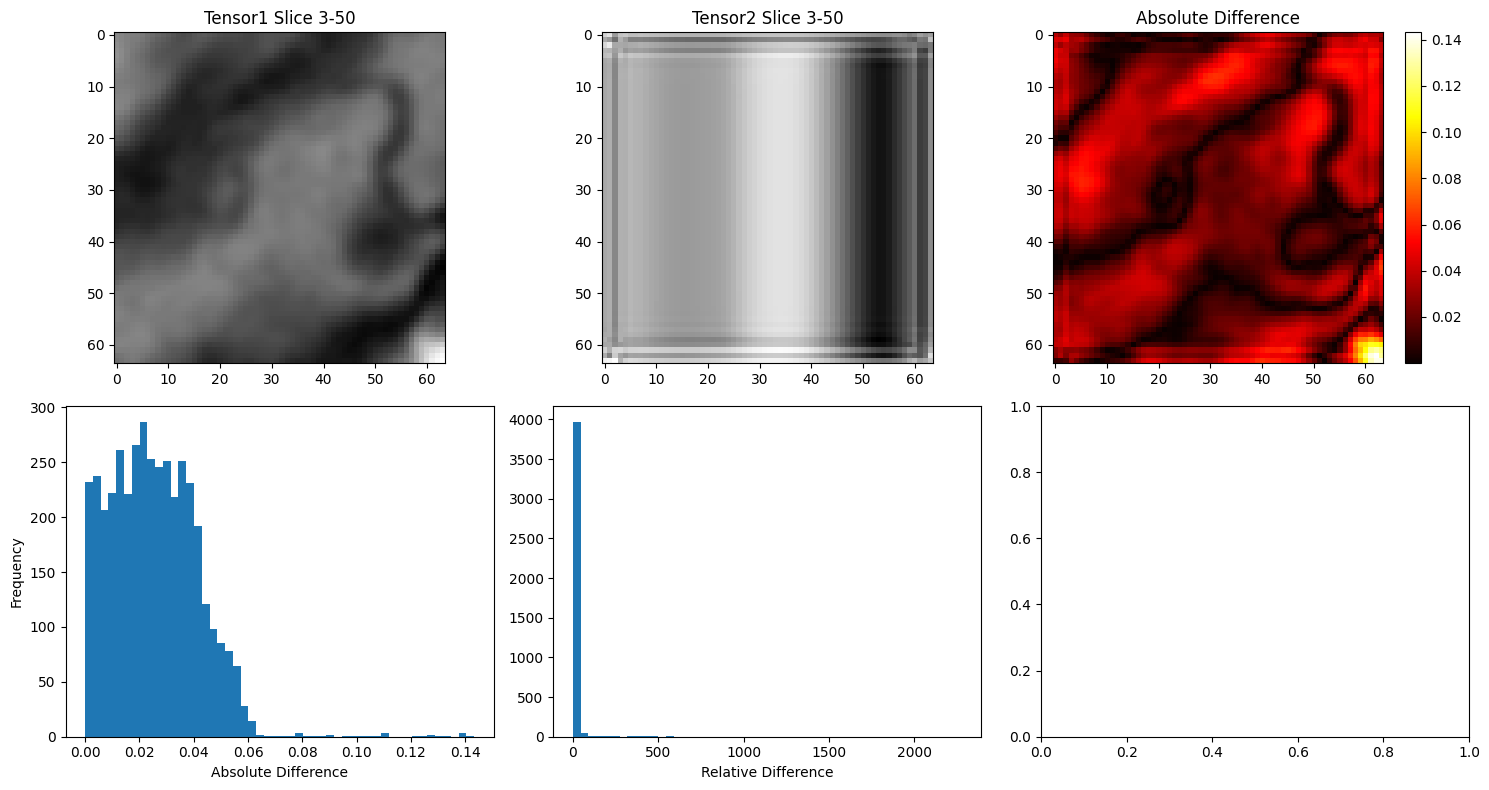

{'max_abs': 0.14324137568473816, 'mean_abs': 0.025444231927394867, 'rel_over_threshold': 0.99951171875}


In [23]:
instance = seismic_data_total[0][0][None,...]
encoded = autoencoder(torch.from_numpy(instance))
instance.shape,encoded[0].shape
stats, fig = compare_4d_slices(torch.from_numpy(instance), encoded[0].detach(), dim=3, index=50)
plt.show()
print(stats)

In [7]:
#@title Latent Dynamics Model
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch import nn, einsum, Tensor
from torch.nn import Module, ModuleList
from typing import  Union, Tuple, Optional, List
from kornia.filters import filter3d
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import sys
# 添加父目录路径
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

# tensor helpers

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

# FSQ是一种标量量化方法，将连续值离散化为有限的级别
class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# 数据预处理器
class SeismicDataProcessor:
    def __init__(self, autoencoder_model, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.autoencoder = autoencoder_model.to(self.device)
        # 在训练模式下不要设置为eval模式
        self.autoencoder.eval()  # 移除这一行

    def encode_to_2d(self, volume_3d):
        """将3D体转换为2D latent表示，同时保存skip features"""
        # 在训练时需要梯度，移除no_grad上下文
        if not isinstance(volume_3d, torch.Tensor):
            volume_3d = torch.tensor(volume_3d, dtype=torch.float32)
        volume_3d = volume_3d.to(self.device)
        latent = self.autoencoder.encoder(volume_3d)
        return latent

    def decode_to_3d(self, latent_2d):
        """使用保存的skip features将2D latent表示转换回3D体"""
        # 移除no_grad上下文，允许梯度传播
        latent_2d = latent_2d.to(self.device)
        volume_3d = self.autoencoder.decoder(latent_2d)
        return volume_3d

# next-predict数据集
class ProcessedPhysicsDataset_next(Dataset):
    def __init__(self, seismic_data, processor, nt=2, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, 256, 256, 256)
            processor: SeismicDataProcessor实例
            nt: 每个样本包含的连续时间步数
            stride: 滑动窗口的步长
        """
        self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        self.processor = processor
        self.model_num = seismic_data.shape[0]
        self.t_total = seismic_data.shape[1]  # 总时间步数
        self.nt = nt  # 每个样本的时间步数
        self.stride = stride  # 滑动窗口步长

        # 计算可能的时间窗口数量
        self.num_windows = max(0, (self.t_total - self.nt) // self.stride) if not self.stride == 0 else 1

        if self.num_windows == 0:
            raise ValueError(f"无法创建窗口：总时间步数{self.t_total}小于所需时间步数{self.nt}")

        print(f"创建数据集：{self.model_num}个模型，每个有{self.num_windows}个时间窗口")

        # 预处理所有数据
        print("预处理数据...")
        self.processed_data = []

        for model_idx in tqdm(range(self.model_num)):
            model_windows = []

            # 对每个可能的时间窗口进行处理
            for window_idx in range(self.num_windows):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt

                # 处理输入序列
                seismic_seq = self.seismic_data[model_idx, start_t:end_t]  # (nt, 256, 256, 256)

                # 修改后的目标序列逻辑 - 目标是下一个时间步序列
                target_start_t = start_t + 1
                target_end_t = end_t + 1

                # 处理目标序列
                if target_end_t <= self.t_total:
                    # 如果目标序列完全在可用范围内
                    seismic_target = self.seismic_data[model_idx, target_start_t:target_end_t]  # (nt, 256, 256, 256)
                else:
                    # 如果目标序列部分超出可用范围，需要填充
                    # 先获取可用部分
                    available_steps = self.t_total - target_start_t
                    if available_steps > 0:
                        seismic_target = self.seismic_data[model_idx, target_start_t:self.t_total]  # (available_steps, 256, 256, 256)

                        # 计算需要填充的步数
                        padding_steps = self.nt - available_steps

                        # 使用最后一个可用时间步进行填充
                        last_step = self.seismic_data[model_idx, -1].unsqueeze(0)  # (1, 256, 256, 256)
                        padding = last_step.repeat(padding_steps, 1, 1, 1)  # (padding_steps, 256, 256, 256)

                        # 拼接可用部分和填充部分
                        seismic_target = torch.cat([seismic_target, padding], dim=0)  # (nt, 256, 256, 256)
                    else:
                        # 如果完全超出范围，全部使用最后一个时间步填充
                        last_step = self.seismic_data[model_idx, -1].unsqueeze(0)  # (1, 256, 256, 256)
                        seismic_target = last_step.repeat(self.nt, 1, 1, 1)  # (nt, 256, 256, 256)

                # 存储每个时间步的latent和skip features
                seismic_seq_latents = []

                # 对每个时间步进行编码
                for t in range(self.nt):
                    # 编码为2D
                    seismic_latent = self.processor.encode_to_2d(seismic_seq[t].unsqueeze(0))

                    seismic_seq_latents.append(seismic_latent)

                # 将时间序列stack在一起
                seismic_seq_latents = torch.stack(seismic_seq_latents)  # (nt, latent_dim, H, W)

                window_data = {
                    'inputs': {
                        'seismic': {
                            'latent': seismic_seq_latents
                        }
                    },
                    'targets': {
                        'seismic': seismic_target
                    },
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t,
                        'target_start_t': target_start_t,
                        'target_end_t': target_end_t
                    }
                }

                model_windows.append(window_data)

            self.processed_data.extend(model_windows)

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]


# 改进的VideoWorld模型
class VideoWorldPhysicsModel(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=512, frame_num=4,act_embedding_num=2):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[5024] * 6,#[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out


In [11]:
#@title 时移数据集
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Parameters MUST match the saved model's configuration ---
# You need to fill these in based on how you trained the model saved in the .pt file
model_z_dim = 64             # Example: Use the Z dimension from training
model_image_size = 64        # Example: Use the H/W dimension from training
model_input_channels = 1     # Example: Use the input channels from training (likely 1 after reshape)
model_latent_dim = 3         # You provided this one
model_init_dim = 64          # Example: Use the initial dimension from training
# --- Potentially also need encoder_layers and decoder_layers if they were non-default ---
# encoder_layers_config = (('consecutive_residual', 2),) * 4 # Default from train function
# decoder_layers_config = (('consecutive_residual', 2),) * 4 # Default from train function

# Define device (ensure it's defined, e.g., 'cuda' or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define file path
f_path = "/content/drive/MyDrive/DiTing2.0"
checkpoint_file_path = f_path + "/ckp/seismic_autoencoder_epoch_5.pt"
print(f"Loading checkpoint from: {checkpoint_file_path}")

# 1. Instantiate the model with the CORRECT parameters
autoencoder = SeismicDimensionAutoencoder(
    z_dim=model_z_dim,
    image_size=model_image_size,
    input_channels=model_input_channels,
    output_channels=model_input_channels, # Output channels usually match input
    latent_dim=model_latent_dim,
    init_dim=model_init_dim,
    # encoder_layers=encoder_layers_config, # Uncomment if non-default used
    # decoder_layers=decoder_layers_config  # Uncomment if non-default used
)
autoencoder = autoencoder.to(device) # Move model to device BEFORE loading state dict if using GPU

# 2. Load the entire checkpoint dictionary
checkpoint = torch.load(checkpoint_file_path, map_location=device)

# 3. Extract the 'model_state_dict' from the loaded dictionary
model_state_dict = checkpoint['model_state_dict']

# 4. Load the extracted state_dict into the model
autoencoder.load_state_dict(model_state_dict)

# Optional: Set the model to evaluation mode if you're doing inference
autoencoder.eval()

print("Successfully loaded pre-trained autoencoder state dict.")


# 创建数据处理器 pre_ae
processor = SeismicDataProcessor(autoencoder, device)

# 加载数据
T = 10
H_plus_1 = 4
stride = 3  #

seismic_data = seismic_data_total

# 创建数据集和加载器
dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=H_plus_1, stride=stride)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 查看数据集大小
print(f"数据集大小: {len(dataset)}")

# 查看第一个批次
for batch in dataloader:
    print("输入形状:")
    print(f"地震数据: {batch['inputs']['seismic']['latent'].shape}") # 地震数据: torch.Size([1, 4, 1, 3, 64, 64])
    # print(f"通道数据: {batch['inputs']['channel']['latent'].shape}")
    print("目标形状:")
    print(f"地震目标: {batch['targets']['seismic'].shape}") # 地震目标: torch.Size([1, 4, 64, 64, 64])
    # print(f"通道目标: {batch['targets']['channel'].shape}")
    print("元数据:")
    print(f"模型索引: {batch['metadata']['model_idx']}")
    print(f"窗口索引: {batch['metadata']['window_idx']}")
    print(f"开始时间: {batch['metadata']['start_t']}") # 最后一步时间窗
    print(f"结束时间: {batch['metadata']['end_t']}")
    break

Using device: cpu
Loading checkpoint from: /content/drive/MyDrive/DiTing2.0/ckp/seismic_autoencoder_epoch_5.pt
--- Initializing SeismicDimensionAutoencoder (for 64x64 latent) ---
Encoder configured:
  Input: (1, 64, 64, 64)
  After layers (before Z collapse): (64, 64, 64, 64)
  After Z collapse (before to_latent): (64, 1, 64, 64)
  Latent Output: (3, 64, 64)
Autoencoder derived from encoder: final_channel_dim=64, z_expand_target_dim=64
Decoder configured:
  Latent Input: (3, 64, 64)
  After Z expand: (64, 64, 64, 64)
  Final Dim before conv_out: 64
  Output: (1, 64, 64, 64)
--- SeismicDimensionAutoencoder Initialization Complete ---
Successfully loaded pre-trained autoencoder state dict.
创建数据集：10个模型，每个有2个时间窗口
预处理数据...


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]

数据集大小: 20
输入形状:
地震数据: torch.Size([1, 4, 1, 3, 64, 64])
目标形状:
地震目标: torch.Size([1, 4, 64, 64, 64])
元数据:
模型索引: tensor([2])
窗口索引: tensor([0])
开始时间: tensor([0])
结束时间: tensor([4])


In [ ]:
#@title LDM training
torch.cuda.empty_cache()
# 初始化VideoWorld模型
model = VideoWorldPhysicsModel(
    image_size=64,
    latent_channels=3,
    frame_num=H_plus_1,
    act_embedding_num=H_plus_1-1
).to(device)

# 设置autoencoder为评估模式并冻结其参数
autoencoder.eval()
for param in autoencoder.parameters():
    param.requires_grad = False

# 训练配置 - 只优化VideoWorld模型的参数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# 训练循环
for epoch in range(num_epochs):
    model.train()  # 确保model处于训练模式
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        # print('\n', batch['inputs']['seismic']['latent'].shape)

        # 准备输入数据
        seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device) # [1,3,T,X,Y]

        # 前向传播
        decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model(seismic_input)  # B, C, T, H, W

        # 使用处于eval模式的autoencoder进行解码
        with torch.no_grad():  # 确保不会计算autoencoder的梯度
            # 如果processor.decode_to_3d内部使用了autoencoder，那么它应该已经处于eval模式
            # 但我们需要确保梯度可以通过seismic_output传播
            decoded_detached = decoded.detach()  # 暂时分离梯度

        # 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
        seismic_output_3d = processor.decode_to_3d(
            decoded # 使用原始的有梯度的输出
        )

        # 计算损失
        seismic_target = batch['targets']['seismic'].to(device)
        recon_loss = F.mse_loss(seismic_output_3d, seismic_target)
        loss = recon_loss

        # 反向传播
        loss.backward(retain_graph=True)

        # 验证梯度是否正确流向model参数
        # has_grad = any(p.grad is not None and torch.sum(torch.abs(p.grad)) > 0 for p in model.parameters())
        # print(f"Model has gradients: {has_grad}")

        optimizer.step()
        total_loss += loss.item()
        print(f"Loss: {loss:.6f}")
    # 输出训练信息
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")
# 8m 23s
    # # 保存检查点
    # if (epoch + 1) % 10 == 0:
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': avg_loss,
    #     }, f"checkpoint_epoch_{epoch+1}.pt")

# 保存最终模型
torch.save(model.state_dict(), f_path+"/ckp/vw_ldm_4_64.pt")